#Imports

In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317145 sha256=e5a9c631ab72172242e0b7212b5df40f12a83789ceb82e10fcc1c3f234291a2f
  Stored in directory: /root/.cache/pip/wheels/9f/34/a4/159aa12d0a510d5ff7c8f0220abbea42e5d81ecf588c4fd884
Successfully built pyspark


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from pyspark.sql import functions as F
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import numpy as np
from pyspark.ml.tuning import CrossValidator
import plotly.graph_objects as go
from pyspark import SparkContext

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules


#EDA

In [3]:
#The data set does not have column as is it coming from URL and it is in a raw format. Assigning Column Name for future operation
colName = ['Age','Sex','ChestPain','BloodPressure','Cholesterol','Sugar','Ecg','HeartRate','Agina',
           'Depression','Peak','Vesels','Thal','Target']

In [6]:

data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data',names = colName )
data.head()

,Age,Sex,ChestPain,BloodPressure,Cholesterol,Sugar,Ecg,HeartRate,Agina,Depression,Peak,Vesels,Thal,Target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [7]:
data.shape

(303, 14)

In [8]:
data.dtypes

Age              float64
Sex              float64
ChestPain        float64
BloodPressure    float64
Cholesterol      float64
Sugar            float64
Ecg              float64
HeartRate        float64
Agina            float64
Depression       float64
Peak             float64
Vesels            object
Thal              object
Target             int64
dtype: object

In [9]:
data["Sex"].unique()

array([1., 0.])

In [10]:
#Checking for missing values
data.isnull()

,Age,Sex,ChestPain,BloodPressure,Cholesterol,Sugar,Ecg,HeartRate,Agina,Depression,Peak,Vesels,Thal,Target
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,False,False,False,False,False,False,False,False,False,False,False,False,False,False
299,False,False,False,False,False,False,False,False,False,False,False,False,False,False
300,False,False,False,False,False,False,False,False,False,False,False,False,False,False
301,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [11]:
#Checking Unique values in Object type columns

for i in range(data.shape[1]):
    a = str(colName[i])
    if data[a].dtype =='O':
        print("'",a,"'", "Unique Val:",data[a].unique(), "dType:", "object","\n")

' Vesels ' Unique Val: ['0.0' '3.0' '2.0' '1.0' '?'] dType: object 

' Thal ' Unique Val: ['6.0' '3.0' '7.0' '?'] dType: object 



In [12]:
#Checking Unique values in Categorical type columns

for i in range(data.shape[1]):
    a = str(colName[i])
    if data[a].dtype =='float64':
        print("'",a,"'", "Unique Val:",data[a].unique(), "dType:", data[a].dtype ,"\n")

' Age ' Unique Val: [63. 67. 37. 41. 56. 62. 57. 53. 44. 52. 48. 54. 49. 64. 58. 60. 50. 66.
 43. 40. 69. 59. 42. 55. 61. 65. 71. 51. 46. 45. 39. 68. 47. 34. 35. 29.
 70. 77. 38. 74. 76.] dType: float64 

' Sex ' Unique Val: [1. 0.] dType: float64 

' ChestPain ' Unique Val: [1. 4. 3. 2.] dType: float64 

' BloodPressure ' Unique Val: [145. 160. 120. 130. 140. 172. 150. 110. 132. 117. 135. 112. 105. 124.
 125. 142. 128. 170. 155. 104. 180. 138. 108. 134. 122. 115. 118. 100.
 200.  94. 165. 102. 152. 101. 126. 174. 148. 178. 158. 192. 129. 144.
 123. 136. 146. 106. 156. 154. 114. 164.] dType: float64 

' Cholesterol ' Unique Val: [233. 286. 229. 250. 204. 236. 268. 354. 254. 203. 192. 294. 256. 263.
 199. 168. 239. 275. 266. 211. 283. 284. 224. 206. 219. 340. 226. 247.
 167. 230. 335. 234. 177. 276. 353. 243. 225. 302. 212. 330. 175. 417.
 197. 198. 290. 253. 172. 273. 213. 305. 216. 304. 188. 282. 185. 232.
 326. 231. 269. 267. 248. 360. 258. 308. 245. 270. 208. 264. 321. 274.
 325. 23

In [13]:
data.nunique()


Age               41
Sex                2
ChestPain          4
BloodPressure     50
Cholesterol      152
Sugar              2
Ecg                3
HeartRate         91
Agina              2
Depression        40
Peak               3
Vesels             5
Thal               4
Target             5
dtype: int64

In [14]:
#Checking Unique values in Categorical type columns

for i in range(data.shape[1]):
    a = str(colName[i])
    if data[a].dtype =='int64':
        print("'",a,"'", "Unique Val:",data[a].unique(), "dType:", data[a].dtype ,"\n")

' Target ' Unique Val: [0 2 1 3 4] dType: int64 



Notice: Target column has 5 categories. From research papers I found that the different categories are the stages of heart disease.(not entirely sure). Our project concerns only with presence or absence of disease, we converted all the categories except 0 into 1s.

In [15]:

#Redefining Target categories , (0,1)

data.loc[data['Target'] == 0, 'Target'] = 0
data.loc[data['Target'] == 1, 'Target'] = 1
data.loc[data['Target'] == 2, 'Target'] = 1
data.loc[data['Target'] == 3, 'Target'] = 1
data.loc[data['Target'] == 4, 'Target'] = 1

In [16]:
data.head()

,Age,Sex,ChestPain,BloodPressure,Cholesterol,Sugar,Ecg,HeartRate,Agina,Depression,Peak,Vesels,Thal,Target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [17]:
# dealing with rows containing unrecognised values

# From above , we know 'Vesels' and 'Thal' columns have the character '?'


data[data["Thal"]== "?"]

#Dropping the rows containing '?'
data = data.drop(data[data["Thal"]== "?"].index)
data['Thal'].unique()


array(['6.0', '3.0', '7.0'], dtype=object)

In [18]:
#Same for colum 'vesels'
data[data["Vesels"]== "?"]

#Dropping the rows containing '?'
data = data.drop(data[data["Vesels"]== "?"].index)
data['Vesels'].unique()

array(['0.0', '3.0', '2.0', '1.0'], dtype=object)

In [19]:
#removing any duplicate rows
data = data.drop_duplicates()

data

,Age,Sex,ChestPain,BloodPressure,Cholesterol,Sugar,Ecg,HeartRate,Agina,Depression,Peak,Vesels,Thal,Target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,57.0,0.0,4.0,140.0,241.0,0.0,0.0,123.0,1.0,0.2,2.0,0.0,7.0,1
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,1
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,1


In [20]:
#changing the dtype of the 'object' columns
data["Vesels"] = pd.to_numeric(data["Vesels"])
data['Thal'] = pd.to_numeric(data['Vesels'])

In [21]:
data.dtypes

Age              float64
Sex              float64
ChestPain        float64
BloodPressure    float64
Cholesterol      float64
Sugar            float64
Ecg              float64
HeartRate        float64
Agina            float64
Depression       float64
Peak             float64
Vesels           float64
Thal             float64
Target             int64
dtype: object

<Axes: >

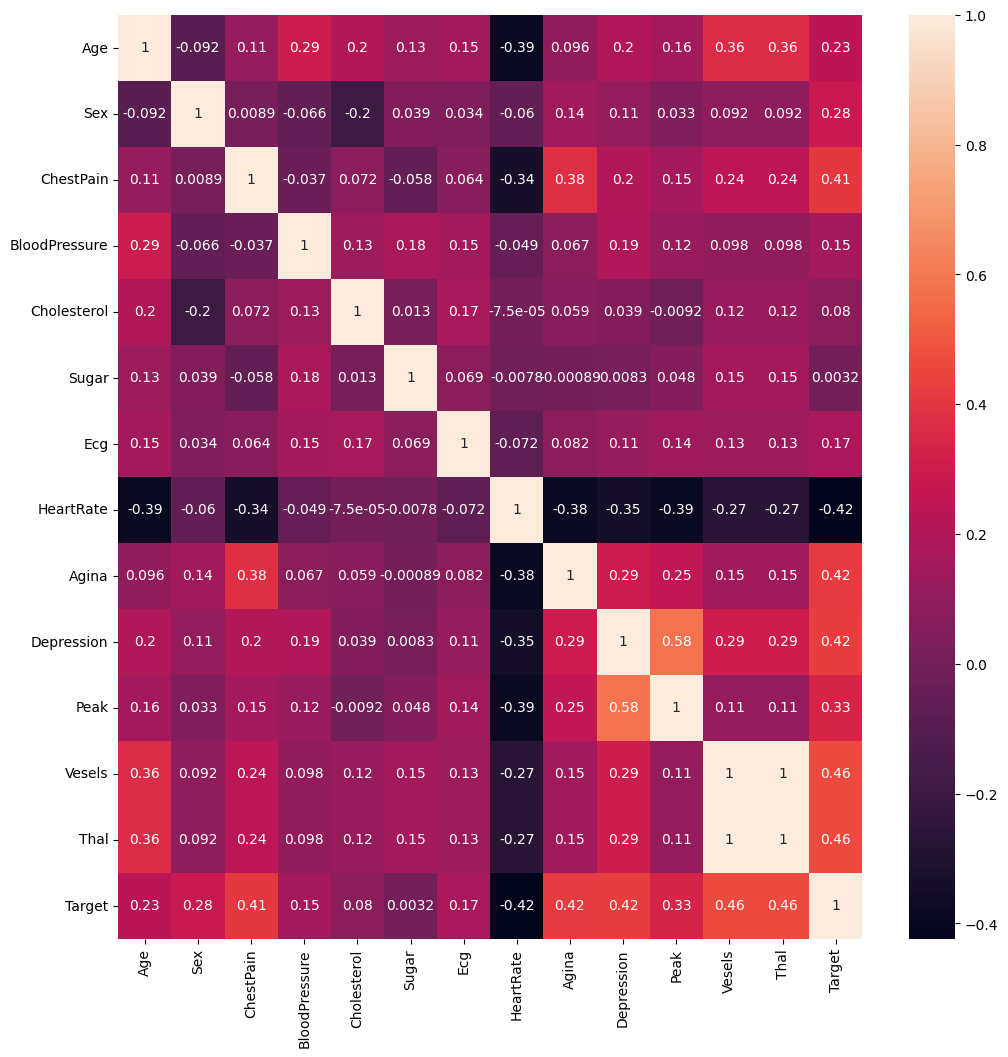

In [22]:
#correlation matrix for all columns
plt.figure(figsize=(12,12))
sns.heatmap(data.corr(),annot=True)


Notice that: Target variable shows high correlation with Thal, Vesels, Peak, depression, Angina and Chest pain. Considering 0.4 and above 'high'.

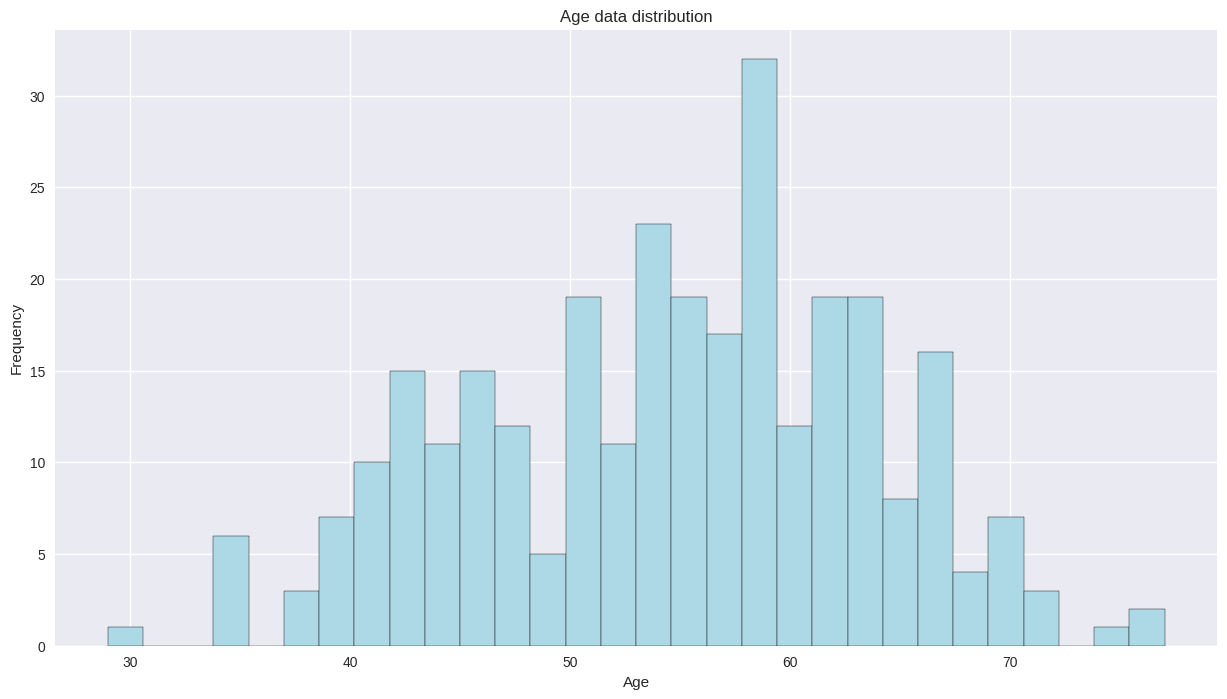

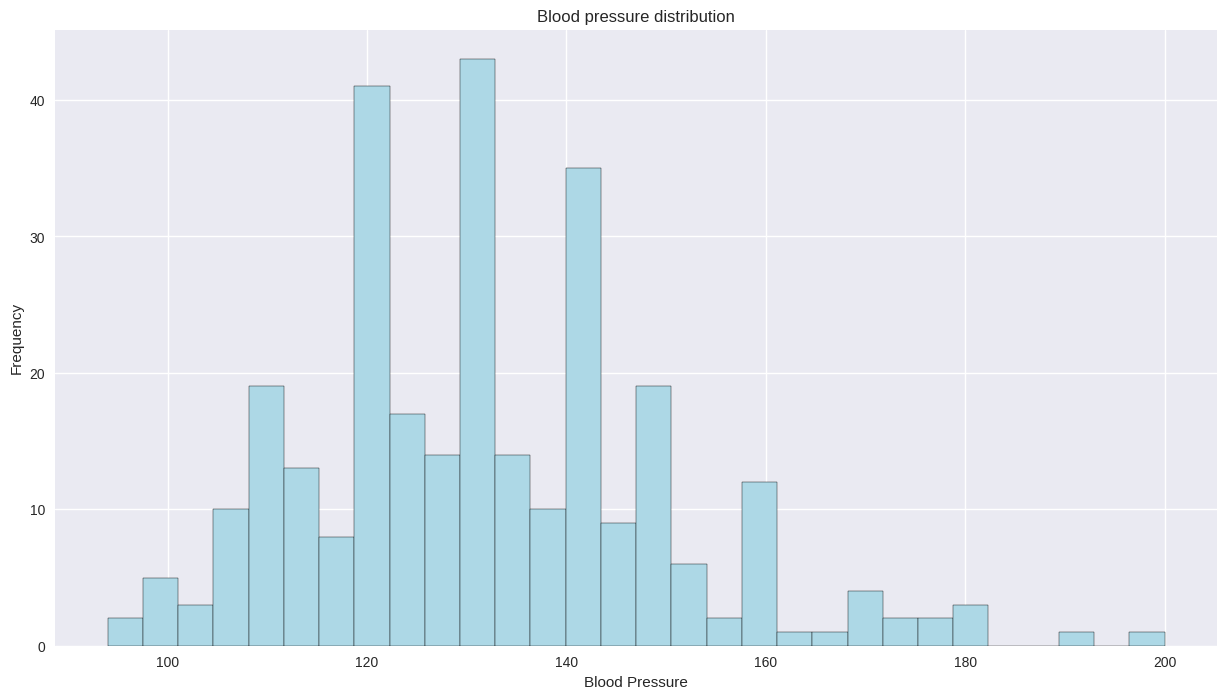

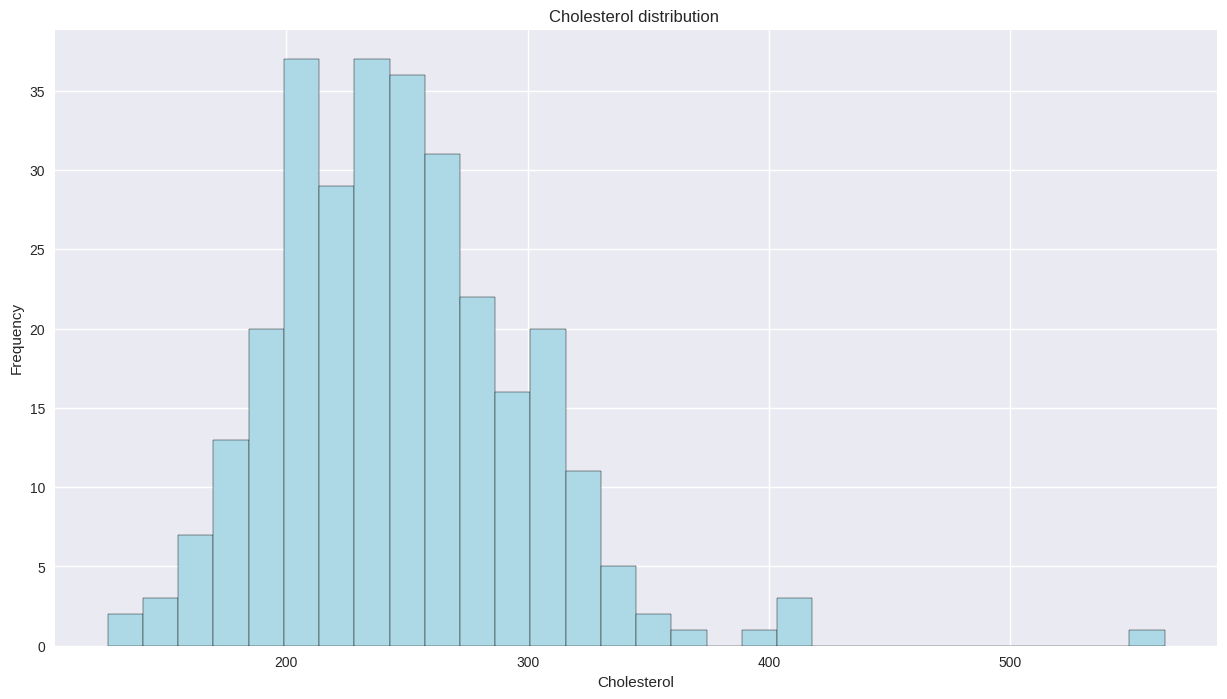

In [23]:
plt.style.use('seaborn')

# checking 'age' for outliers
plt.figure(figsize= (15,8))
plt.hist(data.Age, color= 'lightblue',ec="black", bins=30)
plt.title("Age data distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

# checking 'Bloodpressure ' for outliers 
plt.figure(figsize= (15,8))
plt.hist(data.BloodPressure, color = "lightblue",ec="black", bins = 30)
plt.title("Blood pressure distribution")
plt.xlabel("Blood Pressure")
plt.ylabel("Frequency")
plt.show()


#checking 'cholesterol ' for outliers 
plt.figure(figsize= (15,8))
plt.hist(data.Cholesterol, color = "lightblue",ec="black", bins = 30)
plt.title("Cholesterol distribution ")
plt.xlabel("Cholesterol")
plt.ylabel("Frequency")
plt.show()

## Other useful explorations

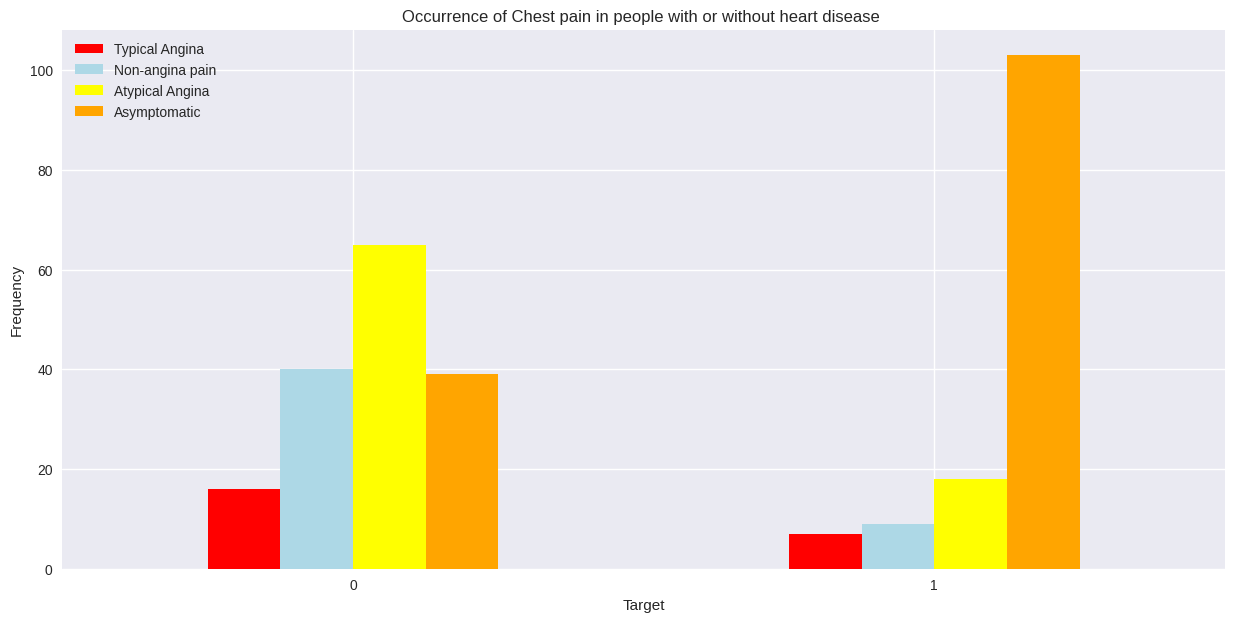

In [24]:
# Chest pains and Presence or absence of disease

pd.crosstab(data.Target,data.ChestPain).plot(kind="bar",figsize = (15,7), color = ["red","lightblue","yellow","orange"])
plt.title("Occurrence of Chest pain in people with or without heart disease ")
plt.xlabel("Target")
plt.xticks(rotation=0)
plt.legend(["Typical Angina","Non-angina pain","Atypical Angina","Asymptomatic"])
plt.ylabel("Frequency")
plt.show()

We see that Asymptomatic chest pain is clearly higher in patients with heart disease. And not every type of chest pain indicates presence of heart disease.

In [25]:

data.to_csv('cl_data.csv')

#Apriori

https://reader.elsevier.com/reader/sd/pii/S1877050915032044?token=067DA1F765032FED65176AB7FEB881EC7B87FBD39E749ACD7CB69C19D6FE1778EA0900F0977285D5F4F56C254E001858&originRegion=us-east-1&originCreation=20230422121124

In [26]:
minimum_threshold = 0.1 #minimum support threshold
minimum_percentage_threshold = 1

In [27]:
data.columns

Index(['Age', 'Sex', 'ChestPain', 'BloodPressure', 'Cholesterol', 'Sugar',
       'Ecg', 'HeartRate', 'Agina', 'Depression', 'Peak', 'Vesels', 'Thal',
       'Target'],
      dtype='object')

In [28]:
data['Target'].unique() 

array([0, 1])

In [29]:
symptoms = ['Age','Sex','Agina','Sugar','Target'] 

In [30]:
#total number of symptoms
ts = len(symptoms)

In [31]:
data2 = data[["Age","Sex","Agina","Sugar","Target"]]

In [33]:
data2.head()

,Age,Sex,Agina,Sugar,Target
0,63.0,1.0,0.0,1.0,0
1,67.0,1.0,1.0,0.0,1
2,67.0,1.0,1.0,0.0,1
3,37.0,1.0,0.0,0.0,0
4,41.0,0.0,0.0,0.0,0


In [32]:
# #dropping columns with target = 0 which denotes heart disease did not happen
# data2.drop(data2[data2['Target'] == 0].index, inplace=True)


In [34]:
data2.head()

,Age,Sex,Agina,Sugar,Target
0,63.0,1.0,0.0,1.0,0
1,67.0,1.0,1.0,0.0,1
2,67.0,1.0,1.0,0.0,1
3,37.0,1.0,0.0,0.0,0
4,41.0,0.0,0.0,0.0,0


In [35]:
data2=data2[["Age","Sex","Agina","Sugar","Target"]].astype(str)
# data2=data2[["Age","Sex","Agina","Sugar","Target"]].astype(str)

In [36]:
list_data = data2.values.tolist()
print(list_data)

[['63.0', '1.0', '0.0', '1.0', '0'], ['67.0', '1.0', '1.0', '0.0', '1'], ['67.0', '1.0', '1.0', '0.0', '1'], ['37.0', '1.0', '0.0', '0.0', '0'], ['41.0', '0.0', '0.0', '0.0', '0'], ['56.0', '1.0', '0.0', '0.0', '0'], ['62.0', '0.0', '0.0', '0.0', '1'], ['57.0', '0.0', '1.0', '0.0', '0'], ['63.0', '1.0', '0.0', '0.0', '1'], ['53.0', '1.0', '1.0', '1.0', '1'], ['57.0', '1.0', '0.0', '0.0', '0'], ['56.0', '0.0', '0.0', '0.0', '0'], ['56.0', '1.0', '1.0', '1.0', '1'], ['44.0', '1.0', '0.0', '0.0', '0'], ['52.0', '1.0', '0.0', '1.0', '0'], ['57.0', '1.0', '0.0', '0.0', '0'], ['48.0', '1.0', '0.0', '0.0', '1'], ['54.0', '1.0', '0.0', '0.0', '0'], ['48.0', '0.0', '0.0', '0.0', '0'], ['49.0', '1.0', '0.0', '0.0', '0'], ['64.0', '1.0', '1.0', '0.0', '0'], ['58.0', '0.0', '0.0', '1.0', '0'], ['58.0', '1.0', '0.0', '0.0', '1'], ['58.0', '1.0', '0.0', '0.0', '1'], ['60.0', '1.0', '1.0', '0.0', '1'], ['50.0', '0.0', '0.0', '0.0', '0'], ['58.0', '0.0', '0.0', '0.0', '0'], ['66.0', '0.0', '0.0', '0.0

In [37]:
#load the list data to a pyspark rdd ... Spark Context 
sc = SparkContext("local" , "Apriori")

In [38]:
rdd = sc.parallelize(list_data)


In [39]:
rddCollect = rdd.collect()
print("Number of Partitions: "+str(rdd.getNumPartitions()))
print("Action: First element: "+str(rdd.first()))
print(rddCollect)

Number of Partitions: 1
Action: First element: ['63.0', '1.0', '0.0', '1.0', '0']
[['63.0', '1.0', '0.0', '1.0', '0'], ['67.0', '1.0', '1.0', '0.0', '1'], ['67.0', '1.0', '1.0', '0.0', '1'], ['37.0', '1.0', '0.0', '0.0', '0'], ['41.0', '0.0', '0.0', '0.0', '0'], ['56.0', '1.0', '0.0', '0.0', '0'], ['62.0', '0.0', '0.0', '0.0', '1'], ['57.0', '0.0', '1.0', '0.0', '0'], ['63.0', '1.0', '0.0', '0.0', '1'], ['53.0', '1.0', '1.0', '1.0', '1'], ['57.0', '1.0', '0.0', '0.0', '0'], ['56.0', '0.0', '0.0', '0.0', '0'], ['56.0', '1.0', '1.0', '1.0', '1'], ['44.0', '1.0', '0.0', '0.0', '0'], ['52.0', '1.0', '0.0', '1.0', '0'], ['57.0', '1.0', '0.0', '0.0', '0'], ['48.0', '1.0', '0.0', '0.0', '1'], ['54.0', '1.0', '0.0', '0.0', '0'], ['48.0', '0.0', '0.0', '0.0', '0'], ['49.0', '1.0', '0.0', '0.0', '0'], ['64.0', '1.0', '1.0', '0.0', '0'], ['58.0', '0.0', '0.0', '1.0', '0'], ['58.0', '1.0', '0.0', '0.0', '1'], ['58.0', '1.0', '0.0', '0.0', '1'], ['60.0', '1.0', '1.0', '0.0', '1'], ['50.0', '0.0', '

In [40]:
data2.dtypes

Age       object
Sex       object
Agina     object
Sugar     object
Target    object
dtype: object

In [41]:
#find the frequency of occurrences for each column ... singletons
age_freq = rdd.map(lambda x: (x[0], 1)).reduceByKey(lambda x, y: x + y)
sex_freq = rdd.map(lambda x: (x[1], 1)).reduceByKey(lambda x, y: x + y)
agina_freq = rdd.map(lambda x: (x[2], 1)).reduceByKey(lambda x, y: x + y)
sugar_freq = rdd.map(lambda x: (x[3], 1)).reduceByKey(lambda x, y: x + y)
print(age_freq.collect())



[('63.0', 9), ('67.0', 9), ('37.0', 2), ('41.0', 10), ('56.0', 11), ('62.0', 11), ('57.0', 17), ('53.0', 7), ('44.0', 11), ('52.0', 11), ('48.0', 7), ('54.0', 16), ('49.0', 5), ('64.0', 10), ('58.0', 18), ('60.0', 12), ('50.0', 7), ('66.0', 7), ('43.0', 7), ('40.0', 3), ('69.0', 3), ('59.0', 14), ('42.0', 8), ('55.0', 8), ('61.0', 8), ('65.0', 8), ('71.0', 3), ('51.0', 12), ('46.0', 7), ('45.0', 8), ('39.0', 4), ('68.0', 4), ('47.0', 5), ('34.0', 2), ('35.0', 4), ('29.0', 1), ('70.0', 4), ('77.0', 1), ('38.0', 1), ('74.0', 1), ('76.0', 1)]


In [42]:
age_gender_freq = rdd.map(lambda x: ((x[0],x[1]), 1)).reduceByKey(lambda x, y: x + y)

In [43]:
age_gender_freq.collect()

[(('63.0', '1.0'), 4),
 (('67.0', '1.0'), 6),
 (('37.0', '1.0'), 1),
 (('41.0', '0.0'), 4),
 (('56.0', '1.0'), 8),
 (('62.0', '0.0'), 7),
 (('57.0', '0.0'), 4),
 (('53.0', '1.0'), 5),
 (('57.0', '1.0'), 13),
 (('56.0', '0.0'), 3),
 (('44.0', '1.0'), 9),
 (('52.0', '1.0'), 10),
 (('48.0', '1.0'), 6),
 (('54.0', '1.0'), 11),
 (('48.0', '0.0'), 1),
 (('49.0', '1.0'), 3),
 (('64.0', '1.0'), 7),
 (('58.0', '0.0'), 6),
 (('58.0', '1.0'), 12),
 (('60.0', '1.0'), 7),
 (('50.0', '0.0'), 3),
 (('66.0', '0.0'), 3),
 (('43.0', '1.0'), 5),
 (('40.0', '1.0'), 3),
 (('69.0', '0.0'), 1),
 (('59.0', '1.0'), 13),
 (('42.0', '1.0'), 6),
 (('55.0', '1.0'), 4),
 (('61.0', '1.0'), 6),
 (('65.0', '0.0'), 4),
 (('71.0', '0.0'), 3),
 (('61.0', '0.0'), 2),
 (('51.0', '1.0'), 8),
 (('50.0', '1.0'), 4),
 (('65.0', '1.0'), 4),
 (('41.0', '1.0'), 6),
 (('51.0', '0.0'), 4),
 (('46.0', '0.0'), 3),
 (('54.0', '0.0'), 5),
 (('46.0', '1.0'), 4),
 (('62.0', '1.0'), 4),
 (('45.0', '1.0'), 5),
 (('53.0', '0.0'), 2),
 (('39

In [44]:
#age-angina
age_angina_freq = rdd.map(lambda x: ((x[0],x[2]), 1)).reduceByKey(lambda x, y: x + y)
#age-sugar
age_sugar_freq = rdd.map(lambda x: ((x[0],x[3]), 1)).reduceByKey(lambda x, y: x + y)
#age-gender-angina
age_gender_angina_freq = rdd.map(lambda x: ((x[0],x[1],x[2]), 1)).reduceByKey(lambda x, y: x + y)
#age-gender-sugar
age_gender_sugar_freq = rdd.map(lambda x: ((x[0],x[1],x[3]), 1)).reduceByKey(lambda x, y: x + y)
#age-gender-angina_sugar 
age_gender_angina_sugar_freq = rdd.map(lambda x: ((x[0],x[1],x[2],x[3]), 1)).reduceByKey(lambda x, y: x + y)

print (age_angina_freq.collect(), "\n",age_sugar_freq.collect() ,"\n",age_gender_angina_freq.collect(),
    "\n", age_gender_sugar_freq.collect(),"\n", age_gender_angina_sugar_freq.collect())

[(('63.0', '0.0'), 5), (('67.0', '1.0'), 3), (('37.0', '0.0'), 2), (('41.0', '0.0'), 9), (('56.0', '0.0'), 5), (('62.0', '0.0'), 9), (('57.0', '1.0'), 8), (('53.0', '1.0'), 3), (('57.0', '0.0'), 9), (('56.0', '1.0'), 6), (('44.0', '0.0'), 9), (('52.0', '0.0'), 10), (('48.0', '0.0'), 6), (('54.0', '0.0'), 11), (('49.0', '0.0'), 5), (('64.0', '1.0'), 5), (('58.0', '0.0'), 13), (('60.0', '1.0'), 5), (('50.0', '0.0'), 6), (('66.0', '0.0'), 4), (('43.0', '0.0'), 5), (('40.0', '1.0'), 2), (('69.0', '0.0'), 3), (('64.0', '0.0'), 5), (('59.0', '0.0'), 9), (('44.0', '1.0'), 2), (('42.0', '0.0'), 7), (('43.0', '1.0'), 2), (('55.0', '1.0'), 5), (('61.0', '1.0'), 5), (('65.0', '0.0'), 8), (('71.0', '0.0'), 3), (('61.0', '0.0'), 3), (('51.0', '0.0'), 5), (('53.0', '0.0'), 4), (('54.0', '1.0'), 5), (('51.0', '1.0'), 7), (('46.0', '1.0'), 3), (('58.0', '1.0'), 5), (('60.0', '0.0'), 7), (('59.0', '1.0'), 5), (('46.0', '0.0'), 4), (('67.0', '0.0'), 6), (('62.0', '1.0'), 2), (('45.0', '1.0'), 3), (('39.

In [45]:
age_gender_angina_sugar_freq_filtered = age_gender_angina_sugar_freq.filter(lambda x: x[1] >= 2)

In [46]:
age_gender_angina_sugar_freq_filtered.collect()[:10]

[(('67.0', '1.0', '1.0', '0.0'), 3),
 (('41.0', '0.0', '0.0', '0.0'), 3),
 (('56.0', '1.0', '0.0', '0.0'), 4),
 (('62.0', '0.0', '0.0', '0.0'), 5),
 (('57.0', '0.0', '1.0', '0.0'), 2),
 (('57.0', '1.0', '0.0', '0.0'), 5),
 (('56.0', '1.0', '1.0', '1.0'), 3),
 (('44.0', '1.0', '0.0', '0.0'), 7),
 (('52.0', '1.0', '0.0', '1.0'), 4),
 (('48.0', '1.0', '0.0', '0.0'), 4)]

In [47]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('SparkByExamples.com').getOrCreate()
# Convert RDD to DataFrame
data = age_gender_angina_sugar_freq_filtered.map(lambda x: (x[0][0], x[0][1], x[0][2], x[0][3], x[1])).collect()
df = spark.createDataFrame(data, schema=["age", "gender", "angina", "sugar", "freq"])
rdd = age_gender_angina_sugar_freq_filtered.map(lambda x: (x[0][0], x[0][1], x[0][2], x[0][3], x[1]))
df = spark.createDataFrame(rdd, schema=["age", "gender", "angina", "sugar", "freq"])
# Show DataFrame
df.show()
# df.to_csv('heart_disease_prediction.csv', index=False)
df.write.mode("overwrite").option("header", "true").csv("heart_disease_prediction.csv")



+----+------+------+-----+----+
| age|gender|angina|sugar|freq|
+----+------+------+-----+----+
|67.0|   1.0|   1.0|  0.0|   3|
|41.0|   0.0|   0.0|  0.0|   3|
|56.0|   1.0|   0.0|  0.0|   4|
|62.0|   0.0|   0.0|  0.0|   5|
|57.0|   0.0|   1.0|  0.0|   2|
|57.0|   1.0|   0.0|  0.0|   5|
|56.0|   1.0|   1.0|  1.0|   3|
|44.0|   1.0|   0.0|  0.0|   7|
|52.0|   1.0|   0.0|  1.0|   4|
|48.0|   1.0|   0.0|  0.0|   4|
|54.0|   1.0|   0.0|  0.0|   7|
|49.0|   1.0|   0.0|  0.0|   3|
|64.0|   1.0|   1.0|  0.0|   4|
|58.0|   0.0|   0.0|  1.0|   2|
|58.0|   1.0|   0.0|  0.0|   7|
|60.0|   1.0|   1.0|  0.0|   4|
|50.0|   0.0|   0.0|  0.0|   3|
|58.0|   0.0|   0.0|  0.0|   3|
|66.0|   0.0|   0.0|  0.0|   2|
|43.0|   1.0|   0.0|  0.0|   4|
+----+------+------+-----+----+
only showing top 20 rows



In [48]:
from pyspark.sql.functions import count, when, col

# Get the RDD values
age_gender_freq = age_gender_angina_sugar_freq_filtered.map(lambda x: ((x[0][0], x[0][1]), x[1])).collectAsMap()

# Use age and gender, and calculate frequency of angina and sugar where there values are 1
grouped_df = df.groupBy(["age", "gender"]).agg(
    count(when(df.angina == 1, True)).alias("angina_count"),    # total values for angina
    count(when(df.sugar == 1, True)).alias("sugar_count"),      # total values for sugar
    count(df.freq).alias("total_count")
)

confidences = {}
confidences_angina = {}
confidences_sugar = {}


for row in grouped_df.collect():
    age = row["age"]
    gender = row["gender"]
    angina_count = row["angina_count"]
    sugar_count = row["sugar_count"]
    support_age_gender = age_gender_freq.get((age, gender), 0)
 
    angina_confidence = angina_count/support_age_gender if support_age_gender > minimum_threshold else 0
    sugar_confidence = sugar_count/support_age_gender if support_age_gender > minimum_threshold else 0
    
    confidences[(age, gender)] = {"angina": angina_confidence, "sugar": sugar_confidence}
    confidences_angina [(age, gender)]= {"Angina":angina_confidence}
    confidences_sugar [(age, gender)]= {"Sugar":sugar_confidence}


print(confidences)
print(confidences_angina)
print(confidences_sugar)

{('58.0', '1.0'): {'angina': 0.25, 'sugar': 0.0}, ('67.0', '1.0'): {'angina': 0.5, 'sugar': 0.0}, ('61.0', '1.0'): {'angina': 0.5, 'sugar': 0.0}, ('51.0', '1.0'): {'angina': 0.16666666666666666, 'sugar': 0.0}, ('59.0', '1.0'): {'angina': 0.25, 'sugar': 0.25}, ('57.0', '1.0'): {'angina': 0.5, 'sugar': 0.5}, ('45.0', '0.0'): {'angina': 0.0, 'sugar': 0.0}, ('46.0', '1.0'): {'angina': 0.0, 'sugar': 0.0}, ('60.0', '0.0'): {'angina': 0.0, 'sugar': 0.0}, ('44.0', '0.0'): {'angina': 0.0, 'sugar': 0.0}, ('41.0', '1.0'): {'angina': 0.0, 'sugar': 0.0}, ('49.0', '1.0'): {'angina': 0.0, 'sugar': 0.0}, ('41.0', '0.0'): {'angina': 0.0, 'sugar': 0.0}, ('48.0', '1.0'): {'angina': 0.0, 'sugar': 0.0}, ('62.0', '1.0'): {'angina': 0.0, 'sugar': 0.0}, ('71.0', '0.0'): {'angina': 0.0, 'sugar': 0.0}, ('54.0', '0.0'): {'angina': 0.0, 'sugar': 0.0}, ('42.0', '1.0'): {'angina': 0.0, 'sugar': 0.0}, ('40.0', '1.0'): {'angina': 0.5, 'sugar': 0.0}, ('53.0', '1.0'): {'angina': 0.5, 'sugar': 0.5}, ('39.0', '0.0'): {'a

testing

#Prediction

In [62]:
# data2.head()
# df.dtypes
# Loading the dataset
# df = pd.read_csv('cl_data.csv')
df = data2
# Creating dummy variables for categorical columns
df = pd.get_dummies(df, columns=['Agina','Sugar'])
df.dtypes
# # Convert non-boolean columns to boolean columns
for col in df.columns:    
    if df[col].dtype != bool:
        print(df[col].dtype)
        df[col] = df[col] != 0

df.dtypes
# df.head(200)



object
object
object
uint8
uint8
uint8
uint8


Age          bool
Sex          bool
Target       bool
Agina_0.0    bool
Agina_1.0    bool
Sugar_0.0    bool
Sugar_1.0    bool
dtype: object

In [52]:
# Importing the required libraries
import pandas as pd
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree

# Loading the dataset
# df = pd.read_csv('cl_data.csv')
df = data2
# Creating dummy variables for categorical columns
df = pd.get_dummies(df, columns=['Agina','Sugar'])

# Convert non-boolean columns to boolean columns
for col in df.columns:
    if df[col].dtype != bool:
        df[col] = df[col] != 0

# Print the converted DataFrame
# print(df)

# Splitting the dataset into training and testing sets
X = df.drop('Target', axis=1)
y = df['Target'] = df['Target'].astype(bool)
#df['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Finding frequent itemsets using Apriori algorithm
frequent_itemsets = apriori(X_train, min_support=0.35, use_colnames=True)
print(frequent_itemsets)

# Generating association rules from frequent itemsets
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=1.0)

# Creating a decision tree classifier using association rules as features
dt = DecisionTreeClassifier()
X_train_rules = X_train[rules['antecedents'].apply(lambda x: list(x)).sum()]
dt1 = dt.fit(X_train_rules, y_train)

# Visualize tree https://mljar.com/blog/visualize-decision-tree/
text_representation = tree.export_text(dt.fit(X_train_rules, y_train))
print(text_representation)

# Predicting on the testing set
X_test_rules = X_test[rules['antecedents'].apply(lambda x: list(x)).sum()]
y_pred = dt1.predict(X_test_rules)

# Calculating accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

     support                          itemsets
0   1.000000                             (Age)
1   1.000000                             (Sex)
2   0.670886                       (Agina_0.0)
3   0.856540                       (Sugar_0.0)
4   1.000000                        (Age, Sex)
5   0.670886                  (Age, Agina_0.0)
6   0.856540                  (Age, Sugar_0.0)
7   0.670886                  (Sex, Agina_0.0)
8   0.856540                  (Sex, Sugar_0.0)
9   0.573840            (Sugar_0.0, Agina_0.0)
10  0.670886             (Age, Sex, Agina_0.0)
11  0.856540             (Age, Sex, Sugar_0.0)
12  0.573840       (Age, Sugar_0.0, Agina_0.0)
13  0.573840       (Sex, Sugar_0.0, Agina_0.0)
14  0.573840  (Age, Sex, Sugar_0.0, Agina_0.0)
|--- class: 0

Accuracy: 1.0


In [53]:
# # df.dtypes
# # df.head()
# # df.dtypes
# print(X)
# print(y)
print(len(X_train),len(X_test))
# print(rules)
print(y_pred)
print(len(y_pred))
print(y_test)

237 60
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True]
60
24     True
64     True
103    True
218    True
288    True
140    True
199    True
130    True
295    True
283    True
241    True
43     True
191    True
254    True
222    True
26     True
65     True
213    True
128    True
267    True
52     True
188    True
234    True
122    True
101    True
115    True
158    True
201    True
120    True
132    True
47     True
165    True
25     True
163    True
290    True
112    True
257    True
221    True
139    True
282    True
76     True
70     True
93     True
177    True
236    True
202    True
138    True
106    True
36     True
10     True
99     True
281    True


In [54]:
# # Importing the required libraries
# import pandas as pd
# from mlxtend.frequent_patterns import apriori
# from mlxtend.frequent_patterns import association_rules
# from sklearn.model_selection import train_test_split
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.metrics import accuracy_score

# # Loading the dataset
# # df = pd.read_csv('cl_data.csv')
# df = data2
# # Creating dummy variables for categorical columns
# df = pd.get_dummies(df, columns=['Agina','Sugar','ChestPain','Age', 'Sex'])


# # Convert non-boolean columns to boolean columns
# for col in df.columns:
#     if df[col].dtype != bool:
#         df[col] = df[col] != 0

# Print the converted DataFrame
# print(df)

# # Splitting the dataset into training and testing sets
# X = df.drop('Target', axis=1)
# y = df['Target'] = df['Target'].astype(bool)
# #df['Target']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Finding frequent itemsets using Apriori algorithm
# frequent_itemsets = apriori(X_train, min_support=0.5, use_colnames=True)
# print(frequent_itemsets)

# # Generating association rules from frequent itemsets
# rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# # Creating a decision tree classifier using association rules as features
# dt = DecisionTreeClassifier()
# X_train_rules = X_train[rules['antecedents'].apply(lambda x: list(x)).sum()]
# dt.fit(X_train_rules, y_train)

# # Predicting on the testing set
# X_test_rules = X_test[rules['antecedents'].apply(lambda x: list(x)).sum()]
# y_pred = dt.predict(X_test_rules)

# Calculating accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 1.0
